In [1]:
%pylab qt
import scipy.integrate as integrate
from IPython import display
matplotlib.rcParams.update({'errorbar.capsize': 2})

Populating the interactive namespace from numpy and matplotlib


In [25]:
# use solve_ivp to find solution from t0=0 up to a max tf (definec on next cell), but stop if x hits x=20.0

diff_n = 3
diffs = concatenate((zeros(1),logspace(-2,0, diff_n, base = 2)))
a0_n = 3
a0s = logspace(0,2,nu_n,base = 2)
nu = 1.0


#diffs = logspace(3,5,3,base=2)

# define domain and lattice
length = 30.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)


diffs,a0s

(array([0.  , 0.25, 0.5 , 1.  ]), array([1., 2., 4.]))

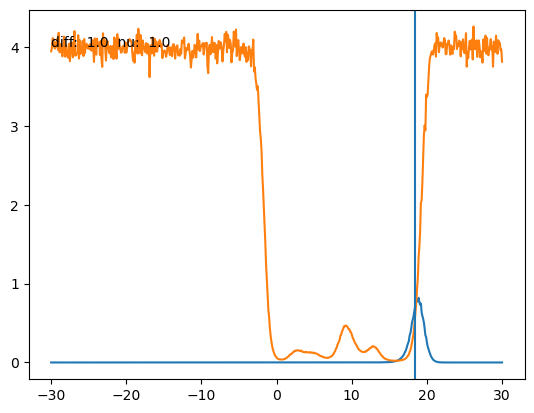

0.9085791776167104


In [26]:
# euler method
# cannot use adaptive timesteps methods


w = 0.0
delta = 0.1


run_n = 50

sol_a0 = []


for a0 in a0s:
    sol_diff = []
    for diff in diffs: 
        print("diffusion coefficient:  ", diff)
        tf = 400.0

        v_run = []
        xp_run = []
        burnt_run = []
        eff_run = []
        t_max_run = []

        for run in range(run_n):
            # A0x = a0*ones(Nx) + 0.1*a0*2.0*(0.5-random.random(Nx))

            xp = 0.0
            As = zeros(Nx)
            As[xs > -10.0] = a0
            Ac = zeros(Nx)
            As = ones(Nx) *a0 + random.normal(0.0,0.1, size = Nx)

            dt = 0.001
            t_max = int(tf/dt)
            xp_t = []
            eff_t = []
            v_t = []
            burnt_t = []

            for t in range(t_max): ## loop through for every time step
                ## first determine total force on hub
                eps = 1e-8
                jj = where(Ac < eps)[0] # check where Acx is very small (and log(Acx) will be a problem)
                Acx_temp = Ac.copy()    # make a temporary copy to change, so that Acx does not need to be changed
                Acx_temp[jj] =  1e-10     
                err = (log(eps)-log(Acx_temp))


                wr = zeros(Nx)
                ii = where(err < 0.0)[0]
                wr[ii] = w*Ac[ii]
                force_unbinding = wr * exp(abs(xp - xs) * delta)

                noise = sqrt(2*dt) * diff* random.normal(0.0,1.0)

                total_f = trapz(-(xp -xs) * Ac, x=xs) 
                binding = exp(-0.5 * (xp - xs) ** 2) * As
                burnt = nu * Ac
                Ac += (binding - burnt -force_unbinding) *dt
                As += (- binding + force_unbinding) * dt
                xp += total_f * dt + noise 
                xp_t.append(xp)
                v_t.append(total_f)
                burnrate = trapz(Ac,x= xs)*nu
                burnt_t.append(burnrate)
                eff_t.append(total_f**2/burnrate)
                
                if t % 1000 == 0 and run == 0:
                    display.clear_output(wait=True)
                    cla()
                    plot(xs,Ac)
                    plot(xs,As)
                    text(-30,a0,"diff:  "+ str(round(diff,2))+"  nu:  "+str(round(nu,2)))
                    axvline(xp)
                    display.display(gcf())
                    #input("Press enter to continue")

                if abs(xp) > length-10:
                    t_max = t+1
                    break
                     
            # take the average and standard deviation of the last 10%
            back = -int(t_max*0.1)
            v_run.append([mean(array(v_t[back:])),std(array(v_t[back:]))])
            burnt_run.append([mean(array(burnt_t[back:])),std(array(burnt_t[back:]))])
            eff_run.append([mean(array(eff_t[back:])),std(array(eff_t[back:]))])
            t_max_run.append(t_max)
            #print("run ",run+1," of ", run_n, " tf: ", t_max*dt, " eff: ", eff_run[-1])
        
        
        sol_diff.append([v_run,burnt_run,eff_run])
        print(mean(array(eff_run)[:,0]))
    sol_a0.append(sol_diff)
sol_a0 = array(sol_a0)
    





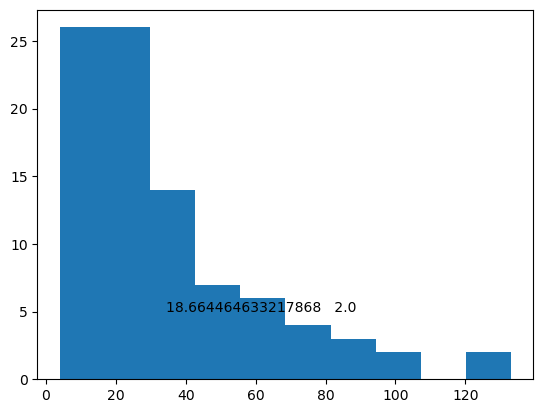

In [30]:
# for average already calculated and stored
# plot efficiency for each run 

for nu in range(a0_n):
    eff = zeros((diff_n+1,2))
    burn = zeros((diff_n+1,2))
    speed = zeros((diff_n+1,2))
    for diff in range(diff_n):
        
        burnave = mean(sol_a0[nu][diff][1][:,0])
        effave = mean(sol_a0[nu][diff][2][:,0])
        speedave = mean(sol_a0[nu][diff][0][:,0])
        
        burnstd = std(sol_a0[nu][diff][1][:,0])
        effstd = std(sol_a0[nu][diff][2][:,0])
        speedstd = std(sol_a0[nu][diff][0][:,0])

        burn[diff,0],burn[diff,1] = burnave,burnstd 
        eff[diff,0],eff[diff,1] = effave,effstd
        speed[diff,0],speed[diff,1] = abs(speedave),speedstd
        print(effave,effstd)
    n = 3
    errorbar(diffs[:n],eff[:,0][:n], yerr = eff[:,1][:n], label = "$a_{tot}$: "+ str(a0)+r" $\nu'$: " +str(nus[nu]))
    #errorbar(diffs,burn[:,0], yerr = burn[:,1], label = "$a_{tot}$: "+ str(a0s[a0])+r" $\nu'$: " +str(a0s[a0]*ratio))
    #errorbar(diffs,speed[:,0], yerr = speed[:,1], label = "$a_{tot}$: "+ str(a0s[a0])+r" $\nu'$: " +str(a0s[a0]*ratio))
    title("Relative efficiency for varying diffusion rates")
    xlabel("D'")
    ylabel(r"$\eta$")
    #yscale("log")
    #xscale("log")
    legend()
    deter= array([0.33574931281694537,0.08226592095092651,0.001874225403442146])
    deter = array([0.33574931281694537, 0.2698453494261984,0.16686577133113725])
    plot(0,deter[nu],"*")

0.3358653795103585 0.0050695284404036756
0.3074321173709188 0.09316108491476312
0.24506401575147596 0.11579396798690772
0.2708152767136346 0.0037690739513013163
0.3383677610674849 0.15436873432903742
0.38129031140710273 0.2018021724657065
0.16661753705096582 0.0013944423715365234
0.19448222277718893 0.0740476288666076
0.362787473618996 0.16979033418615216


In [29]:
nu= 1.0

dt = 0.001
t_max = int(400.0/dt)

for a0 in a0s:
    xp = 0.0
    As = zeros(Nx)
    As[xs > 0.0] = a0
    Ac = zeros(Nx)
    eff_t = []

    for t in range(t_max): ## loop through for every time step

        total_f = trapz(-(xp -xs) * Ac, x=xs) 
        binding = exp(-0.5 * (xp - xs) ** 2) * As
        burnt = nu * Ac
        Ac += (binding - burnt ) *dt
        As += - binding* dt
        xp += total_f * dt
        burnrate = trapz(Ac,x= xs)*nu
        eff_t.append(total_f**2/burnrate)
        
        if xp > 20.0:
            break
    print(eff_t[-1])
    print(nus)

0.33574931281694537
[1. 2. 4.]
0.2698453494261984
[1. 2. 4.]
0.16686577133113725
[1. 2. 4.]


In [123]:
sigmas = array([0.010570600353505374,0.004102654797699597,0.017606370134392653])
randoms = array([0.38096681781364333,0.3357944867956096,0.07684926074698585])
deteriministic = array([0.3802554860386229,0.33574931281694537,0.08226592095092651])
names = ["0.5","1.0","2.0"]
bar(names, 2*sigmas, bottom = randoms - sigmas , width = 0.5, label = "stochastic")
plot(deteriministic,".", color = "red", label = "deterministic")
title("Deterministic and Stochastic Efficiency for Zero Diffusion")
ylabel(r"$\eta$")
xlabel(r"$\nu'$")
legend()